In [1]:
from IPython.display import display, HTML, Image
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from obspy import read, UTCDateTime
from obspy.signal import konnoohmachismoothing
from tqdm import tqdm

## Functions

In [3]:
def get_traces(st,stas):
	data = []
	for sta in stas:
		st_sta = st.copy()
		st_sta = st.select(station=sta)
		for tr in st_sta:
			data.append(tr.data)
	return np.array(data).T

def get_psd(data,psd3,nch,npers,nfft,sr,avmethod='median'):
	for j in tqdm(range(nch)):
		chanj = data[:,j]
		#PSD - Cross Power Spectral Density - using Welch’s method.
		for i in range(nch):   
			chani = data[:,i]			
			# Frequencies and Magnitude PSD
			freqs, psd = signal.csd(chanj, chani, fs = sr, nperseg=npers,average=avmethod,noverlap=None, window='hann')
			psd3[j,i,:] = np.abs(psd)
	return np.array(psd3), freqs

def get_svd(psd3,Uall,Sall,nmode):
	for i in range(psd3.shape[2]):
		psd3_freq = psd3[:,:,i]
		U, s, Vh = np.linalg.svd(psd3_freq)
		Uall[i,:] = U[:,0]
		for val in range(nmode):
			Sall[i,val] = s[val]
	return Uall,Sall

def plot_fdd(freqs,Sall,nmode,smooth=True):
	plt.figure(figsize=(20,10))
	for val in tqdm(range(nmode)): 
		if smooth:
			ss_smooth = konnoohmachismoothing.konno_ohmachi_smoothing(Sall[:,val],freqs, bandwidth=80, count=1)
		else:
			ss_smooth = Sall[:,val]
		plt.loglog(freqs, 10*np.log10(ss_smooth),zorder=2,c='grey',alpha=0.95)
		if val == 0:
			from scipy.signal import find_peaks
			peaks, _ = find_peaks(ss_smooth, distance=5)
			for peak in peaks:
				if freqs[peak] >= 0.3 and freqs[peak] <= 10:
					plt.text(freqs[peak], 10*np.log10(ss_smooth[peak]),s=round(freqs[peak],2),fontsize=14)
	plt.xlim([0.2,20])
	plt.ylim([1,100])
	plt.tick_params(axis='both', which='both', labelsize=15)
	plt.xlabel('Frequency [Hz]',fontsize=22)
	plt.ylabel('SVD',fontsize=22)
	plt.grid('on','both',zorder=0)
	plt.tight_layout()
	plt.savefig('Figures/FDD.png')
	return

# Building Information

![Bologna Building](Building.png)

In [4]:
stations = ['RE008', 'RE001', 'RE002', 'RE003', 'RE004', 'RE005', 'RE006']

In [5]:
results = {key: {'Z':[],'N':[],'E':[]} for key in stations}

# Read Data

In [6]:
starttime = UTCDateTime(2023,11,12,0,0,0)
timedelta=60
h = 1*timedelta
endtime = starttime+(h*timedelta)

In [7]:
st = read(f'Data/Noise/*',format='MSEED',starttime=starttime,endtime=endtime)
st = st.select(channel='EH*')
st.sort()

24 Trace(s) in Stream:

LK.RE001..EHE | 2023-11-12T00:00:00.000000Z - 2023-11-12T01:00:00.000000Z | 250.0 Hz, 900001 samples
...
(22 other traces)
...
LK.RE008..EHZ | 2023-11-12T00:00:00.000000Z - 2023-11-12T01:00:00.000000Z | 250.0 Hz, 900001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

## Remove Vertical Components

In [8]:
for tr in st:
	if tr.stats.channel[-1] == 'Z':
		st.remove(tr)

In [10]:
data = get_traces(st, stations)

In [11]:
data.shape

(900001, 14)

## PSD Parameters

In [12]:
npers = 1024*2*16 # Length of each segment
nfft = npers//2+1
nch = data.shape[1] # number of shannel
psd3 = np.zeros((nch,nch,nfft)) # 3D array "(j,i,freqs)"
sr = st[0].stats.sampling_rate

# Calculate SVD

In [13]:
psd3, freqs = get_psd(data,psd3,nch,npers,nfft,sr)

100%|███████████████████████████████████████████| 14/14 [00:09<00:00,  1.50it/s]


### Create SVD Results Matrices

In [14]:
nmode = data.shape[1]
Sall = np.zeros([psd3.shape[2],nmode])
Uall = np.zeros((nfft,nch))

In [15]:
Uall, Sall = get_svd(psd3,Uall,Sall,nmode)

# Plot Results

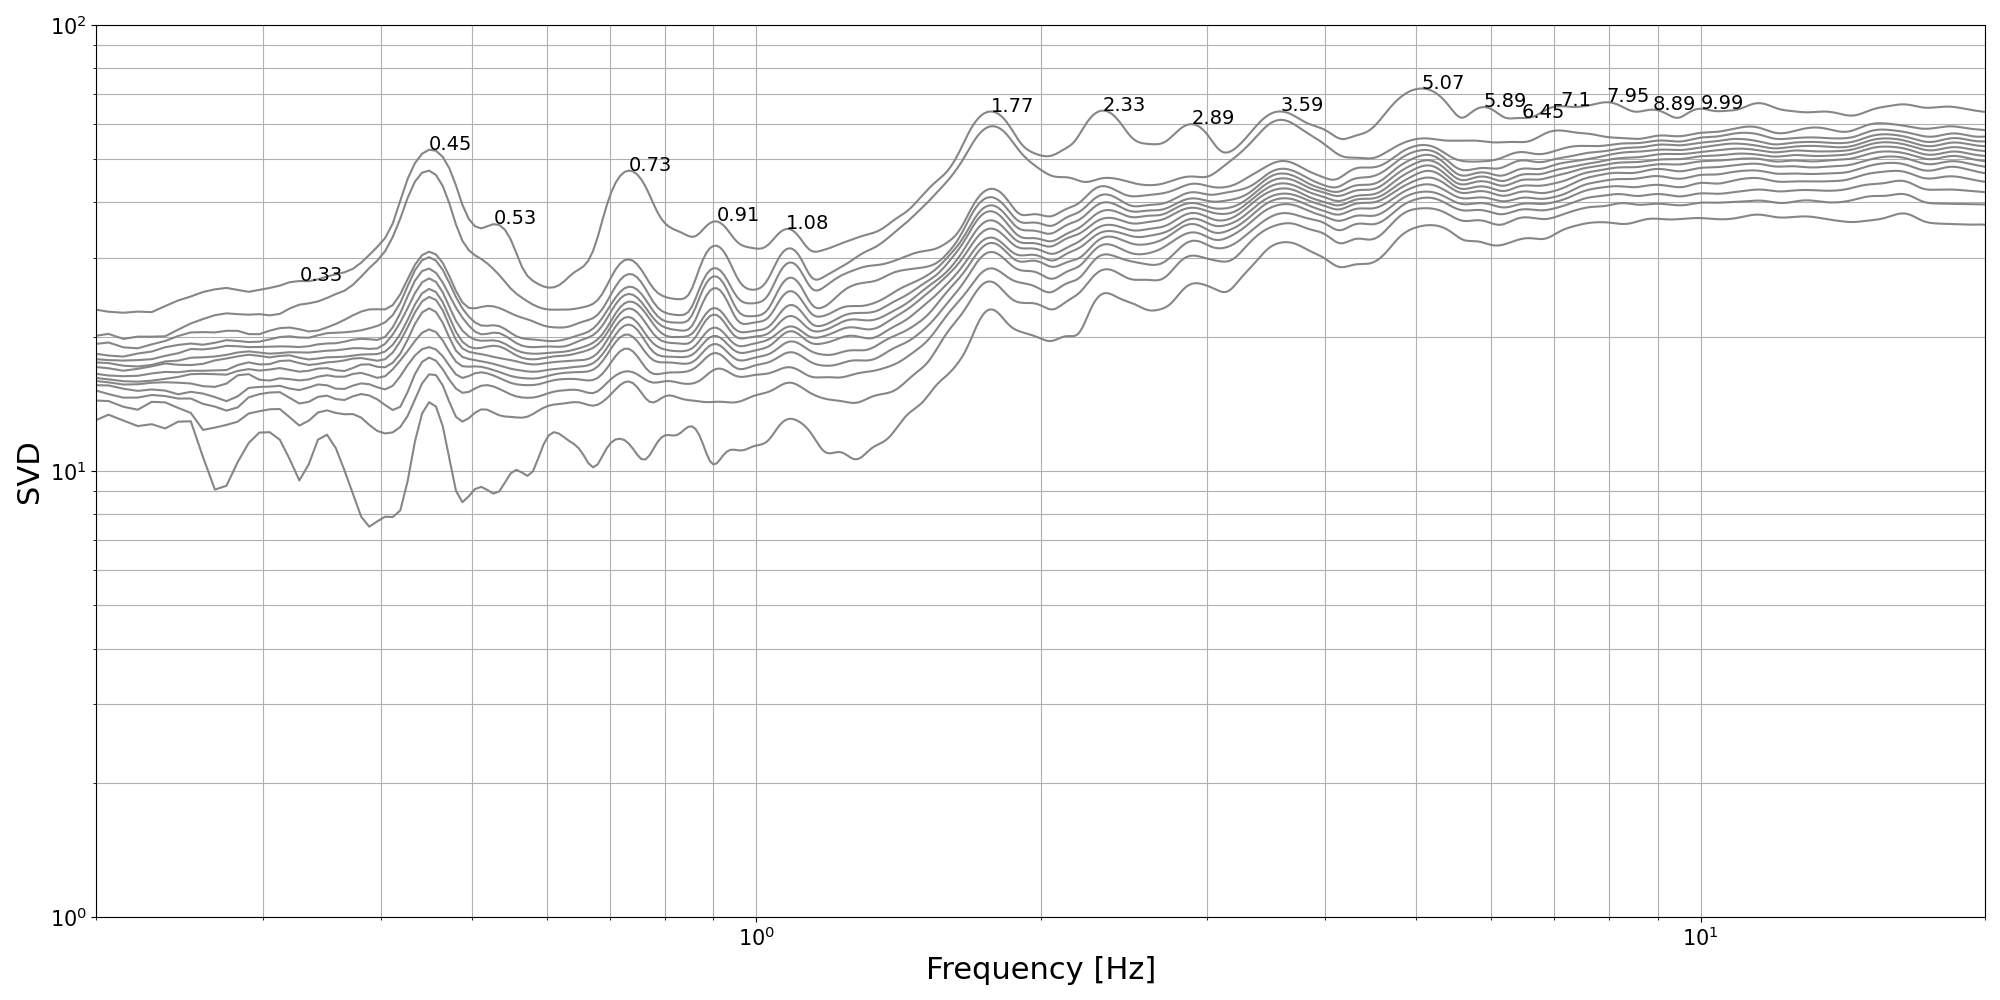

In [18]:
Image(filename='Figures/FDD.png')

100%|███████████████████████████████████████████| 14/14 [01:24<00:00,  6.02s/it]


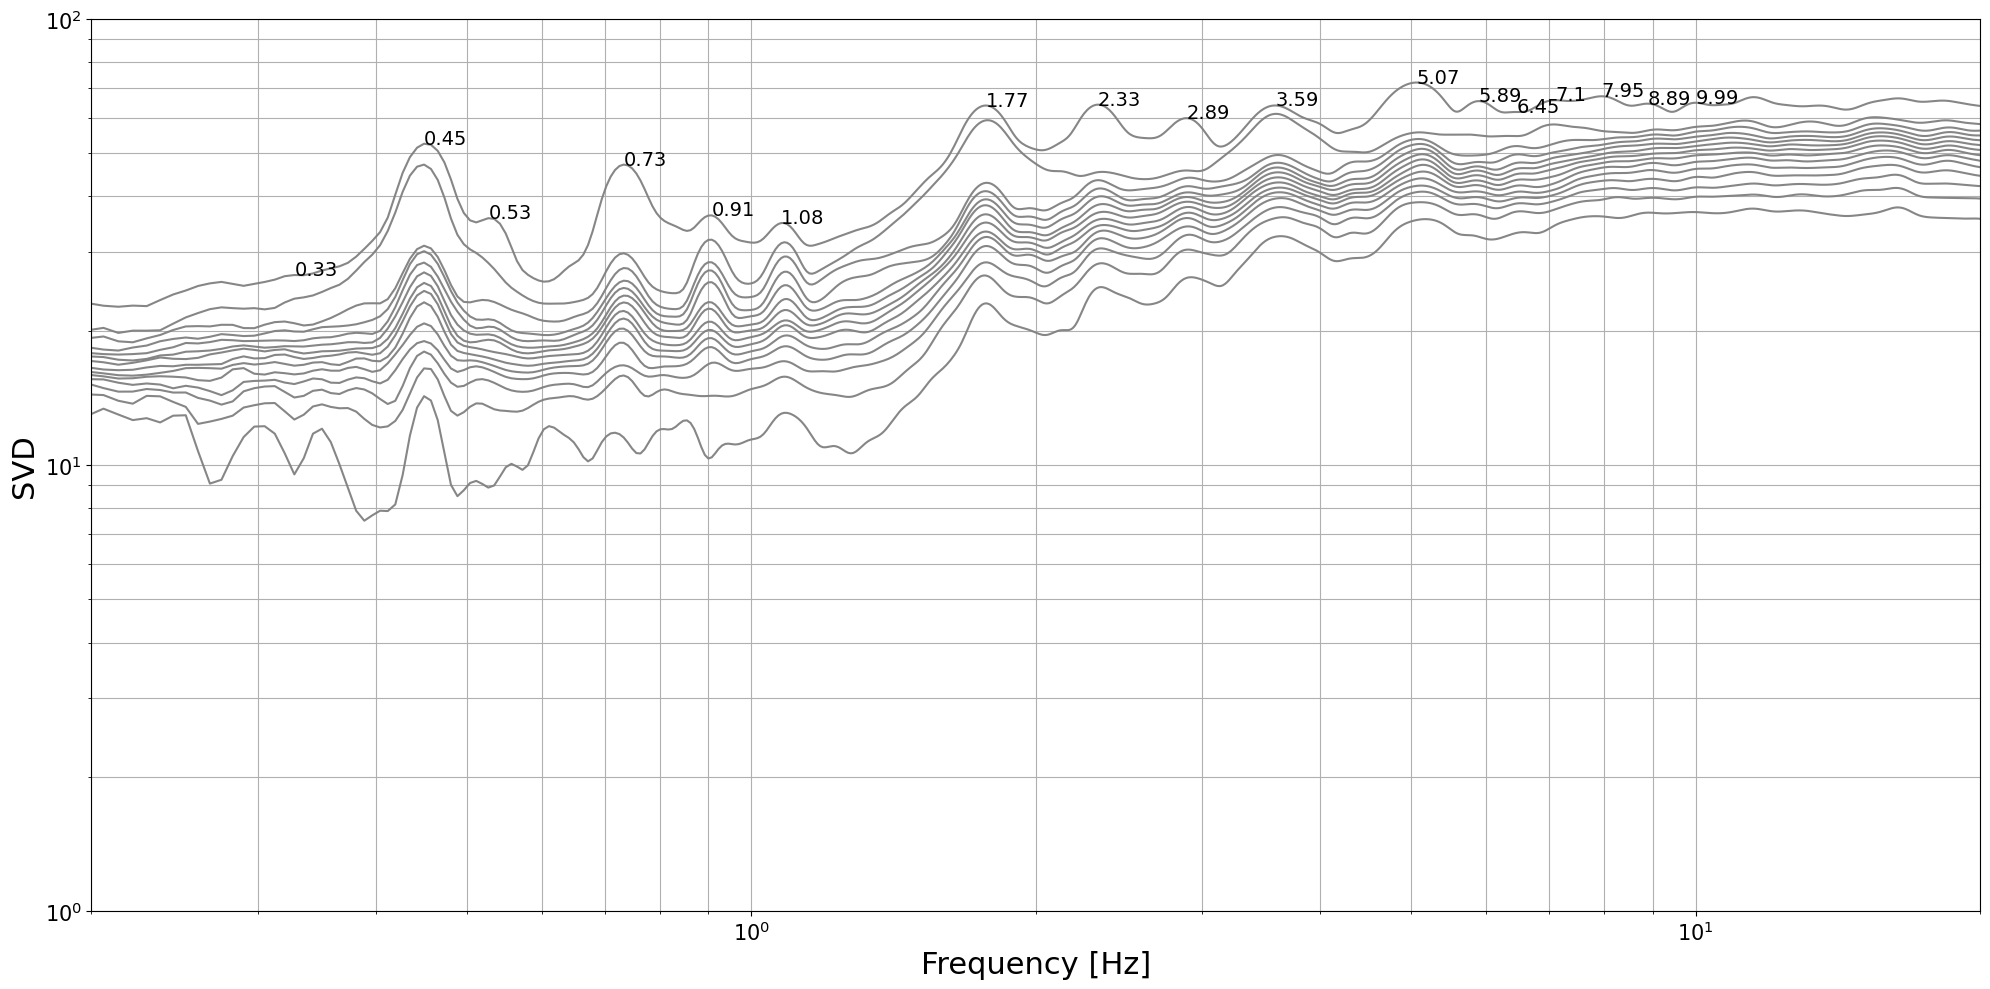

In [17]:
plot_fdd(freqs,Sall,nmode)